# Language Model and Sentiment Analysis

Some common NLP applications with text classification : 
- Spam detection
- Identifying fake news
- Diagnosis of medical records

## Few pointers :

- `fastai.text` module is used for NLP
- For NLP we create two models : Language models and Tuner
- SOTA on IMDB is ~95%
- Always use original stats of the pretrained model datasets. 

E.g. classifying different types of green frogs, if we  used our own per channel mean and std (0,1) would convert things to gray. So when using a pretrained model on ImageNet (1000 classes), we must use the ImageNet stats for standardization.

## Activation functions

- Identity
- Binary step
- Logistic AKA Sigmoid AKA Soft step
- Softmax
- Tanh  
etc ..

## Optimizers

- SGD
- ADAM
- RMSprop

Universal function approximators : It can approximate anything. We just need to find the parameter/weight matrices via gradient descent.

Old/traditional NLP methods mostly used n-grams e.g. A bigram would be 'San Francisco'.

## Sentiment Analysis : Movie Review

> Idea : Language Model (WikiText 103) -> Language Model (IMDb) -> Classifier (IMDb)

- 1 bit of information representing sentiments.

- We start out with randomly initialized weight matrices. However, if we use transfer learning we have good weight matrices. A pretrained model in NLP would be a Language Model.  

- A language model predicts the next word in a sentence/phase. n-grams were used previously (not very good in terms of performance).

- If we train a neural network to predict the next word, it can complete sentences. It would learn english in a way. 

> Idea : Learning about the world through text (language).

- Using a general pretrained language model on say **WikiText 103**, we can then train another language model which is specifically good at predicting next words in movie reviews with IMDb as the target corpus (corpus is a collection of documents).

- Self-supervised learning since we don't need labels for the second language model. It just needs to capture the context in the target corpus and be great at predicting the next word in similar setting.

- Karpathy in his Phd, created a language model of text in LateX documents and then automatically generate papers in LateX.



In [0]:
# magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

The **IMDb dataset**
- 100,000 reviews
- 25,000 labelled as positive and negative for training 
- 25,000 labelled for testing
- 50,000 unlabelled

Using a sample of the dataset,

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [5]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [8]:
df.shape

(1000, 3)

In [9]:
df['text'][3]

'Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man\'s life - interestingly enough the man\'s entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie "Duty, Honor, Country" are not just mere words blathered from the lips of a high-brassed officer - it is the deep declaration of one man\'s total devotion to his country.<br /><br />Ironically Peck being the liberal that he was garnered a better understanding of the man. He does a great job showing the fearless general tempered with the humane side of the man.'

If we ignore the flag, we can create a databunch as follows,

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [24]:
data_lm

TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos xxmaj he now has a name , an identity , some memories and a a lost girlfriend . xxmaj all he wanted was to disappear , but still , they traced him and destroyed the world he hardly built . xxmaj now he wants some explanation , and to get ride of the people how made him what he is . xxmaj yeah , xxmaj jason xxmaj bourne is back , and this time , he 's here with a vengeance . 
 
  xxup ok , this movie does n't have the most xxunk script in the world , but its thematics are very clever and ask some serious questions about our society . xxmaj of course , like every xxmaj xxunk movie since the end of the 90 's , " xxmaj the xxmaj bourne xxmaj suprematy " is a super - heroes story . xxmaj jason xxmaj bourne is a xxmaj captain - xxmaj america project - like , who 's gone completely wrong . xxmaj in the first movie , the hero discovered his abilities and he accepted them in the second one . xxmaj he now fights against what he c

`TextDataBunch` does both tokenization and numericalization behind the scenes.

In [0]:
data_lm.save()

To load a text databunch,

In [0]:
data = load_data(path)

### Tokenization

In [27]:
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl')]

In [0]:
data = load_data(path)

In [29]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


### Numericalization

- Conversion of tokens to integers
- Keep tokens that appear atleast twice
- Max default vocab size is 60,000
- Replace the others by UNK - Not common enough!
- `itos` stands for int to string
- We use the ids to replace the tokens
- Every token in vocab would have a row in the weight matrix of the NN, so restrict to 60000 (default)
- Special tokens like `xx` field if we have title, abstract, body etc

In [17]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [18]:
data.train_ds[0][0]

Text xxbos xxmaj as a baseball die - hard , this movie goes contrary to what i expect in a sports movie : authentic - looking sports action , believable characters , and an original story line . xxmaj while " xxmaj angels in the xxmaj xxunk " fails miserably in the first category , it succeeds beautifully in the latter two . " xxmaj angels " weaves the story of xxmaj roger and xxup j.p. , two xxmaj xxunk foster kids in love with baseball but searching for a family , with that of the xxunk xxmaj angels franchise , struggling to draw fans and win games . xxmaj pushed by his xxunk father 's promise that they would be a family only when the xxmaj angels win the xxunk , xxmaj roger asks for some heavenly help , and gets it in the form of diamond - dwelling xxunk bent on xxunk the franchise 's downward spiral . xxmaj and , when short - xxunk manager xxmaj george xxmaj knox ( portrayed by xxmaj danny xxmaj glover ) begins believing in what xxmaj roger sees , the team suddenly has hope for tur

Numericalized version :

In [19]:
data.train_ds[0][0].data[:10]

array([   2,    5,   27,   13, 1164,  760,   24,  260,   11,   21])

### With data block API

Use datablock API for a more flexible approach  rather than using the factory methods (with fastai defaults) as above. We have to manually call : tokenization and numericalization steps. 

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
       .split_from_df(col=2)
       .label_from_df(cols=0)
       .databunch())

Grabbing the full dataset,

In [0]:
path = untar_data(URLs.IMDB)

In [32]:
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train')]

In [33]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

## Language Model

Also start with good weights with transfer learning such as a **Wikitext 103** language model. No reason to start with random weights. Then we can fine tune this language model on the IMDb dataset to create another language model for our purposes because the english used form IMDb reviews isn't the same as the english used for Wikipedia.

> Note : We can use the text in test set to train the language model. Use all of the text from the dataset to train the language model. Here we can make use unlabelled data to train the language model!

`usup` here means unsupervised i.e. without labels. For a language model, the labels are its own text! 

The rules are all listed below, here is the meaning of the special tokens:

    UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
    PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
    BOS (xxbos) represents the beginning of a text in your dataset
    FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
    TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
    TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
    TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
    TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})
    
Let's create a databunch of the full IMDb dataset and prepare it for training a language model with weights initialized from the WikiText 103 pretrained language model.


In [0]:
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train', 'test', 'unsup'])
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=42)) # batch size

data_lm.save('data_lm.pkl')

Load the databunch for the language model,

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=42)

In [37]:
data_lm.show_batch()

idx,text
0,", get tattoos , hang about doing nothing , etc . etc , xxmaj they generally imagine themselves to be hard and every so often shout challenging rap chants into the camera . xxmaj filmed in xxup mtv style , fast cuts , crazy camera angles , tight close ups and animation interludes . xxmaj the dialogue might have been crisper in the original languages of xxmaj mandarin and xxmaj"
1,remind the viewer of the classic van dam films . parts of the plot do n't make sense and seem to be added in to use up time . the end plot is that of a very basic type that does n't leave the viewer guessing and any twists are obvious from the beginning . the end scene with the flask backs do n't make sense as they are added
2,"'re asked to say , and should n't be believed . xxmaj the fact that the injured policeman supports xxmaj jackson is moderately plausible , but still a bit convenient ( and what if he had died ? ) i find it hard to believe that the xxup kkk would march down the street in broad daylight . xxmaj other apparently serious crimes ( riot , arson , kidnapping ,"
3,""" xxunk "" . xxmaj and it would have helped if the dialogue had n't been swamped by noisy locations or scenes flooded with distracting and inappropriate music . xxmaj the plot is ludicrous : xxmaj the lost xxmaj charles xxmaj dickens story supposedly helps our hero solve a series of modern murders , but so would a copy of xxmaj herge 's xxmaj adventures xxmaj of xxmaj tintin ,"
4,", really , that 's how it starts ) . xxmaj just then he gets a visit by his agent and best friend . xxmaj he mentions to her that he has learned from the paper that a certain millionaire has died , which takes the story 14 years back . xxmaj he can still see and is about to direct his next film . xxmaj he stars the inexperienced"


> Note : For RNNs, decreasing the momentum helps.

Now we create a RNN learner (here we are using **AWD_LSTM** instead of **Wikitext 103** for transfer learning)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


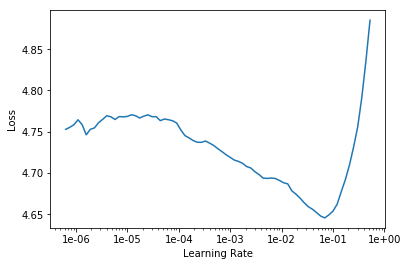

In [41]:
learn.recorder.plot(skip_end=15)

Fine tuning the last layers,

In [42]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.166260,4.043005,0.295039,49:30


> Note : Accuracy of ~0.3 is good enough initially. For limited domain documents like medical and legal transcripts, we can have even higher accuracy.

In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

Let's fine tune the model now. First we unfreeze the layers i.e. make them trainable and then train them for a few more epochs.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-03, moms(0.8, 0.7)) # note : this takes a few hours

In [0]:
learn.save('fine_tuned')

Lets see how well our language model predicts the next word given a few words,

In [0]:
text = 'I liked this movie because'
n_words = 40
n_sentences = 2

In [47]:
print("\n".join(learn.predict(text, n_words, temperature=0.75) 
                for _ in range(n_sentences)))

I liked this movie because i was very surprised to see the movie . The Spanish director , Ang Lee , is a fan of Hollywood and do n't know if the movie has been done . There 's
I liked this movie because of the acting . i seriously enjoyed the movie . This really good movie is a great movie to watch . Bad acting and the good acting , terrible acting and cinematography . The acting is terrible


It does not make a whole lot of sense, but atleast it not completely random. We only care about the **encoder** inside the model and not neccesarily the part that predicts the next word. 

> Think of the language model as having two parts : 
1. The encoder understands the sentences i.e. the part responsible for creating and updating the hidden states in a RNN  
2. The decoder predicts the next word  


Lets save the encoder part as follows,

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

The vocab for the classifier needs to be the same as the vocab used for training the language model.

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=42))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=42)

In [57]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
xxbos * * * xxup spoilers * * * * * * xxup spoilers * * * xxmaj continued ... \n \n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking,neg
"xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film history immediately . xxmaj praise for the film was absolutely nonexistent , even from the people involved in making it . xxmaj this film was loathed from day one . xxmaj while every now and then one will come across some maverick who will praise the film on philosophical grounds ( aggressive feminism",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n \n xxmaj so , i approached watching this the way i 'd approach doing homework . \n \n i",pos
xxbos xxmaj it has said that xxmaj the xxmaj movies and xxmaj baseball both thrived during xxmaj the xxmaj great xxmaj depression . xxmaj it appears that the grim realities of a xxmaj nation caught up in the aftermath of this xxmaj economic xxmaj disaster created a need for occasional relief for the populace . a temporary escape could be found in the on going soap opera that is xxmaj,pos


Now create a model to classify those reviews and load the encoder we save previously,

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

Change the dropout accordingly (to counter overfitting or underfitting)

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 2.09E-02


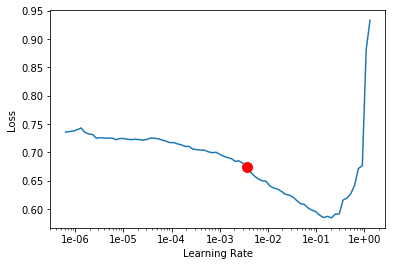

In [62]:
learn.recorder.plot(suggestion=True)

In [63]:
learn.fit_one_cycle(1, 2e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.417254,0.348688,0.851400,05:47


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

Now rather than unfreezing, 

In [0]:
learn.freeze_to(-2) # unfreeze the last two layers

Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.09E-06


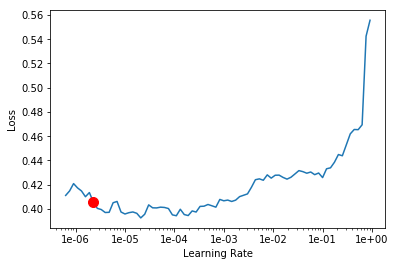

In [70]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

> Note : As we are using discriminative learning rates, we are using a factor of **1/(2.6^4)** for lower layers. For NLP RNN **2.6** was found by using a random forest with different hyperparameters. We can use RF to find optimal hyperparameters.

In [71]:
 # why were these learnin rates chosen?
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.324650,0.220821,0.913880,07:08


We are already getting 91% here! We can continue with this approach and keep on training,

In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [78]:
learn.freeze_to(-3) # unfreeze the last 3 layers
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.249512,0.182321,0.930680,10:09


In [0]:
learn.save('stage-3')

In [0]:
learn.load('stage-3');

Now unfreezing all the layers and training one last time,

In [82]:
learn.unfreeze() # unfreeze all the layers
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.238269,0.171374,0.937400,12:18


In [0]:
learn.save('final')

This gives us a 93% accuracy. 

> Note : Here only the encodings from the initial language model (with minimal fine-tuning) was used. Accuracy can be improved with a better encodings from a language model trained on more number of epochs.

## Sentiment prediction

Now lets see how the model predicts the sentiments of the following (made-up) reviews,

In [83]:
learn.predict("I really loved that movie, and it was awesome!")

(Category pos, tensor(1), tensor([1.0743e-04, 9.9989e-01]))

In [85]:
learn.predict("The movie wasn't that great.")

(Category neg, tensor(0), tensor([0.7747, 0.2253]))

In [87]:
learn.predict("Absolutely terrible movie. Although I really liked the acting and the cinematography.")

(Category neg, tensor(0), tensor([0.9891, 0.0109]))